In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import requests
from pycocotools.coco import COCO
from tqdm.auto import tqdm

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

/home/ayushman/miniconda3/envs/d2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
register_coco_instances("my_dataset_train", 
                        {}, 
                        "/mnt/data1/ayushman/datasets/coco_dataset/annotations/densepose_train2014_cse.json", 
                        "/mnt/data1/ayushman/datasets/coco_dataset/train2014/")

In [4]:
metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

[09/22 02:17:37 d2.data.datasets.coco]: Loading /mnt/data1/ayushman/datasets/coco_dataset/annotations/densepose_train2014_cse.json takes 8.71 seconds.
[09/22 02:17:37 d2.data.datasets.coco]: Loaded 26437 images in COCO format from /mnt/data1/ayushman/datasets/coco_dataset/annotations/densepose_train2014_cse.json


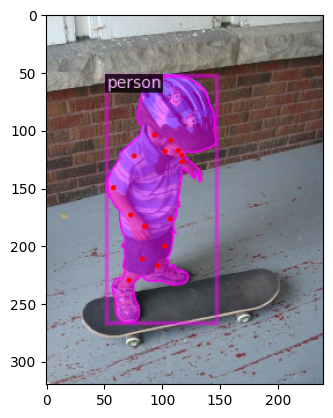

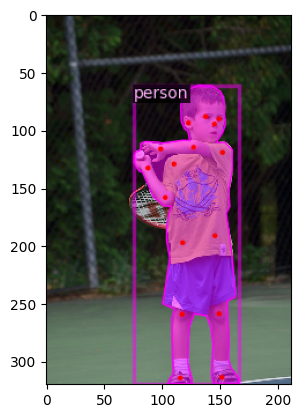

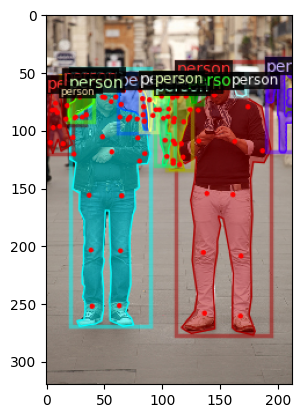

In [5]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.show()

In [6]:
import shutil

In [7]:
for d in tqdm(dataset_dicts, dynamic_ncols=True):
    fp = d['file_name']
    shutil.copyfile(fp, os.path.join("/mnt/data1/ayushman/datasets/coco_dataset/human",os.path.basename(fp)))

  0%|                                                                                                         …

In [1]:
from PIL import Image

In [2]:
image = Image.open('/mnt/data1/ayushman/projects/clothes_preprocessor/data/coco_dataset/annotations/human_parsing/COCO_train2014_000000000036.png')

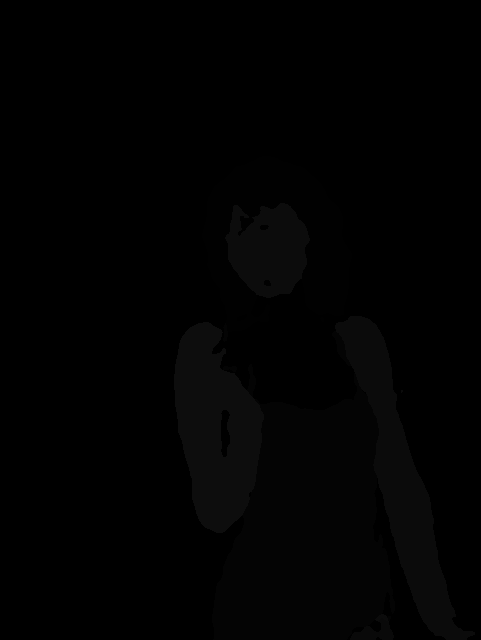

In [3]:
image

In [5]:
import numpy as np

In [8]:
np.unique(np.asanyarray(image))

array([ 0,  1,  4,  9, 11, 12, 13], dtype=uint8)